In [1]:
import os 
import re 
import warnings
from datetime import datetime as time

from typing import Iterable
from collections import Counter
from multiprocessing import Pool

import artm
import pandas as pd

warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
#from preprocessing_tools import lemmatization
from preprocessing_tools import lemmatization

In [3]:
data = pd.read_csv('../data/sport.csv.bz2')

In [4]:
data.shape

(60849, 7)

In [31]:
data.head()

,1914-lenta/,url,edition,topics,title,text,topic
0,1999-10-08 12:00:00,https://lenta.ru/news/1999/10/08/boxing/,NaN,Мир,Дочь Мухаммеда Али дебютирует на ринге,"Лейла Али, дочь известного боксера-тяжеловеса ...",Спорт
1,1999-10-09 12:00:00,https://lenta.ru/news/1999/10/09/football/,NaN,Россия,"Россия — Украина: ничья 1:1, Франция выиграла ...",В субботу 9 октября на Большой спортивной арен...,Спорт
2,1999-10-13 12:00:00,https://lenta.ru/news/1999/10/13/football/,NaN,Мир,Звезд английского футбола стало выгодно похищать,"Как стало известно в среду, клубы футбольной п...",Спорт
3,1999-10-18 12:00:00,https://lenta.ru/news/1999/10/18/formula1/,NaN,Мир,Гонки в Малайзии стали роковыми для команды Fe...,"Как сообщает The Times, в воскресенье, 17 октя...",Спорт
4,1999-12-01 12:00:00,https://lenta.ru/news/1999/12/01/club/,NaN,Экономика,Переговоры с Лондонским клубом опять ничем не ...,1 декабря во Франкфурте-на-Майне завершился оч...,Спорт


In [32]:
CLEANER = re.compile(r'[^А-Яа-я0-9ёA-Za-z\s]', flags=re.U | re.I | re.M)
MULTIPLE_SPACES = re.compile(r'\s+')

CORPUS_NAME = 'viz_sport'
BATCHES_FOLDER = 'batches'

def clean_text(text: str) -> str:
    result = CLEANER.sub(' ', text)
    return MULTIPLE_SPACES.sub(' ', result).strip().lower()

In [33]:
with Pool(8) as p:
    corpus = p.map(clean_text, data.text)

In [34]:
corpus[:2]

['лейла али дочь известного боксера тяжеловеса мухаммеда али дебютирует в том же бизнесе в котором стал известен ее отец первый профессиональный бой лейлы состоится в пятницу в казино turning stone в вероне штат нью йорк уже назначены и следующие три боя лейлы я собираюсь отправить ее в нокаут заявила лейла по прозвищу мадам батерфляй имея в виду свою первую соперницу 27 летнюю эприл фаулер с которой она проведет четыре раунда боя в пятницу правда как сообщает bbc бой не будет транислироваться по телевидению и даже записываться на видео по просьбе самой лейлы которая нервничает однако на шоу по свидетельствам его устроителей уже собралось около 90 журналистов со всего света по словам лейлы ее мать вероника третья жена мухаммеда али тоже придет посмотреть дебютное выступление юной боксерши а вот придет ли на шоу отец неизвестно проработавший 21 год на ринге и теперь страдающий болезнью паркинсона мухаммед али отрицательно относится к решению дочери заняться профессиональным боксом сопер

In [35]:
corpus = map(lemmatization, corpus)

In [10]:
def _to_vw_format(name: str, corpus_iter: Iterable) -> bool:
    with open(f'{name}.vw', 'w') as vw_corpus:
        for doc_id, text in enumerate(corpus_iter):
            word_counter = Counter(text)
            doc = ' '.join([f'{k}:{v}' for k, v in word_counter.items()])
            vw_corpus.write(f'{doc_id} | {doc}\n')
    return True

In [39]:
def _to_vw_format(name: str, corpus_iter: Iterable) -> bool:
    with open(f'{name}.vw', 'w') as vw_corpus:
        for did, text in enumerate(corpus_iter):
            vw_corpus.write('{} | {}\n'.format(did, ' '.join(text)))
            
    return True

In [40]:
_to_vw_format(CORPUS_NAME, corpus)

True

In [42]:
!head -2 viz_sport.vw

0 | 16 летний хоккеист адам литтекен выступать команда школа американский сента луис скончаться тренировка литтекен партнёр разминаться занятие юноша неожиданно упасть лёд потерять сознание игрок доставить местный больница врач констатировать смерть associated press стадион приехать скорый хоккеист пытаться оказать помощь врач команда литтекен отсутствовать пульс тренер партнёр игрок падение лёд сталкиваться хоккеист попадать шайба литтекен выступать команда школа francis howell central учиться 2200 несчастный случай школа специально направить детский психолог
1 | сборная англия понести очередной кадровый потеря менее неделя матч оборочный турнир евро 2008 против россия 17 известно центральный полузащитник манчестер юнайтед майкл каррик трещина локоть выбыть строй срок полтора месяц bbc news каррик повреждение матч групповой турнир лига чемпион манчестер юнайтед рома часы окончание встреча степень серьёзность травма оставаться неизвестный сделать рентгеновский снимка подтвердить плохой

In [43]:
def gather_batches(corpus_name, batches_folder):
    batch_vec = artm.BatchVectorizer(data_path=f'{corpus_name}.vw',
                                     data_format='vowpal_wabbit',
                                     target_folder=batches_folder)
    dictionary = artm.Dictionary()
    dictionary.gather(data_path=batches_folder)
    dictionary.save(f'{batches_folder}/{corpus_name}.dict')
    return batch_vec

In [44]:
batch_vec = gather_batches(CORPUS_NAME, BATCHES_FOLDER)

In [45]:
!python create_cooc_data.py batches 15

59 batches were found, start processing
Process batch: 0
Finished batch, elapsed time: 1.634000301361084
Process batch: 1
Finished batch, elapsed time: 1.5443353652954102
Process batch: 2
Finished batch, elapsed time: 1.1917941570281982
Process batch: 3
Finished batch, elapsed time: 1.8754370212554932
Process batch: 4
Finished batch, elapsed time: 1.2298903465270996
Process batch: 5
Finished batch, elapsed time: 1.1730828285217285
Process batch: 6
Finished batch, elapsed time: 1.7935881614685059
Process batch: 7
Finished batch, elapsed time: 1.5972890853881836
Process batch: 8
Finished batch, elapsed time: 1.577789068222046
Process batch: 9
Finished batch, elapsed time: 2.016347646713257
Process batch: 10
Finished batch, elapsed time: 1.912757396697998
Process batch: 11
Finished batch, elapsed time: 1.310725450515747
Process batch: 12
Finished batch, elapsed time: 1.8584821224212646
Process batch: 13
Finished batch, elapsed time: 1.8798530101776123
Process batch: 14
Finished batch, ela

In [46]:
cooc_dict = artm.Dictionary()
cooc_dict.gather(
    data_path='batches',
    cooc_file_path='cooc_data.txt',
    symmetric_cooc_values=True)

cooc_dict.filter(min_tf=10, max_df_rate=0.2)

artm.Dictionary(name=b545deaa-dc4c-4580-8890-9ee78347cf08, num_entries=20255)

In [47]:
model_list = []
step, coherences, perplexity, sTheta, sPhi = [], [], [], [], []

for i in range(20, 25, 1):
    print(f'#topic {i}.........')
    step.append(i)
    date_start = time.now()
    
    num_topics = i
    model = artm.ARTM(num_topics=num_topics, dictionary=cooc_dict)
    
    # scores
    coherence_score = artm.TopTokensScore(
                            name='TopTokensCoherenceScore',
                            class_id='@default_class',
                            num_tokens=15,
                            dictionary=cooc_dict)
    
    model.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=cooc_dict))
    model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
    model.scores.add(coherence_score)
    
    # first regularizer
    model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))
    model.fit_offline(batch_vectorizer=batch_vec, num_collection_passes=10)
    
    # second one
    model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
    model.fit_offline(batch_vectorizer=batch_vec, num_collection_passes=5)
    
    # third regularizer
    model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
    model.fit_offline(batch_vectorizer=batch_vec, num_collection_passes=15)

    model_list.append(model)
    
    sparsityTheta = model.score_tracker['SparsityThetaScore'].last_value
    sTheta.append(sparsityTheta)
    sparsityPhi = model.score_tracker['SparsityPhiScore'].last_value
    sPhi.append(sparsityPhi)
    perpl = model.score_tracker['PerplexityScore'].last_value
    perplexity.append(perpl)
    coherence = model.score_tracker['TopTokensCoherenceScore'].last_average_coherence
    coherences.append(coherence)
    
    print(f'\tSparsityThetaScore: {sparsityTheta}')
    print(f'\tSparsityPhiScore: {sparsityPhi}')
    print(f'\tPerplexityScore: {perpl}')
    print(f'\tCoherenceScore: {coherence}')
    
    print('\ttime:',time.now() - date_start)

#topic 20.........
	SparsityThetaScore: 0.7698845863342285
	SparsityPhiScore: 0.8168452382087708
	PerplexityScore: 1360.0650634765625
	CoherenceScore: 680.74853515625
	time: 0:00:27.872636
#topic 21.........
	SparsityThetaScore: 0.7743103504180908
	SparsityPhiScore: 0.8238106966018677
	PerplexityScore: 1335.182373046875
	CoherenceScore: 671.67724609375
	time: 0:00:28.959401
#topic 22.........
	SparsityThetaScore: 0.7847816348075867
	SparsityPhiScore: 0.8275061249732971
	PerplexityScore: 1316.20361328125
	CoherenceScore: 679.611328125
	time: 0:00:30.456647
#topic 23.........
	SparsityThetaScore: 0.789788007736206
	SparsityPhiScore: 0.8322346806526184
	PerplexityScore: 1300.062255859375
	CoherenceScore: 670.1444702148438
	time: 0:00:31.965530
#topic 24.........
	SparsityThetaScore: 0.7927480340003967
	SparsityPhiScore: 0.8365197777748108
	PerplexityScore: 1285.893310546875
	CoherenceScore: 629.0869140625
	time: 0:00:32.367456


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Text(0.5, 1.0, 'SparsityPhiScore')

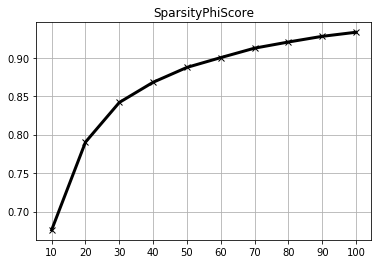

In [17]:
plt.plot(step, sPhi, color='k',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('SparsityPhiScore')

In [18]:
index_sphi = []
[index_sphi.append(float(str(i)[:3]) ) for i in sPhi]
    
index_sphi = list(set(index_sphi))
index_sphi.sort()

In [19]:
d_sphi = {}

for j in range(len(index_sphi)):
    k=0
    for i in sPhi:
        if j==range(len(index_sphi))[-1]:
            if (i>=index_sphi[j]):
                k+=1
        else:
            if (i>=index_sphi[j]) & (i<index_sphi[j+1]):
                k+=1
    d_sphi[index_sphi[j]]=k

Text(0.5, 1.0, 'SparsityThetaScore')

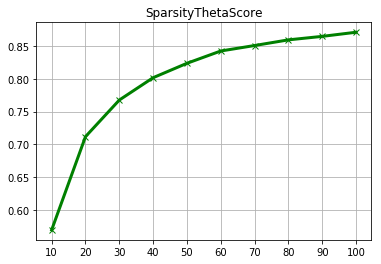

In [20]:
plt.plot(step, sTheta, color='g',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()

plt.title('SparsityThetaScore')

In [21]:
index_theta = []
[index_theta.append(float(str(i)[:3])) for i in sTheta]
    
index_theta = list(set(index_theta))
index_theta.sort()

In [22]:
d_stheta = {}

for j in range(len(index_theta)):
    k=0
    for i in sTheta:
        if j==range(len(index_theta))[-1]:
            if (i>=index_theta[j]):
                k+=1
        else:
            if (i>=index_theta[j]) & (i<index_theta[j+1]):
                k+=1
    d_stheta[index_theta[j]]=k

Text(0.5, 1.0, 'PerplexityScore')

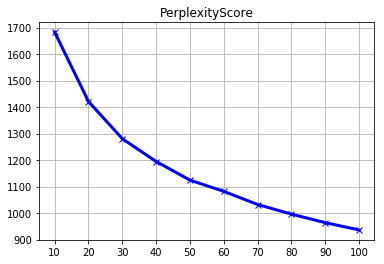

In [23]:
plt.plot(step, perplexity, color='b',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('PerplexityScore')

Text(0.5, 1.0, 'CoherenceScore')

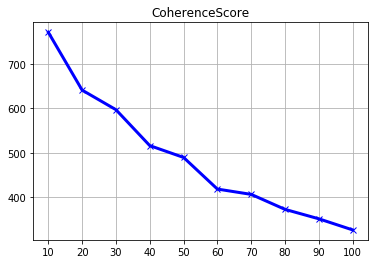

In [24]:
plt.plot(step, coherences, color='b',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('CoherenceScore')

In [25]:
best_model = model_list[-1]

In [26]:
phi = best_model.get_phi()
phi['word'] = phi.index
#phi.head()

for col in phi.columns:
    if col != 'word':
        print(f"{col}: {phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10]}")

topic_0: ['госдума' 'депутат' 'законопроект' 'закон' 'поправка' 'внести' 'комитет'
 'инициатива' 'чтение' 'предложить']
topic_1: ['фонд' 'подпись' 'матвиенко' 'сбор' 'доход' 'собрать' 'валентин'
 'собирать' 'лист' 'декларация']
topic_2: ['письмо' 'телефон' 'обращение' 'просьба' 'доклад' 'мобильный' 'связь'
 'башкирия' 'обратиться' 'голодовка']
topic_3: ['развитие' 'институт' 'проект' 'программа' 'центр' 'создание' 'академия'
 'наука' 'научный' 'культура']
topic_4: ['документ' 'организация' 'деятельность' 'должный' 'закон' 'федеральный'
 'согласно' 'информация' 'министерство' 'подписать']
topic_5: ['флот' 'корабль' 'морской' 'лодка' 'вмф' 'адмирал' 'подводный' 'северный'
 'черноморский' 'мор']
topic_6: ['ущерб' 'фирма' 'мошенничество' 'васильев' 'хищение' 'деньга' 'имущество'
 'продать' 'следствие' 'сумма']
topic_7: ['россиянин' 'опрос' 'опросить' 'мнение' 'считать' 'рейтинг' 'респондент'
 'центр' 'страна' 'исследование']
topic_8: ['губернатор' 'регион' 'округа' 'областной' 'автономный'

topic_96: ['путин' 'государство' 'сказать' 'страна' 'вопрос' 'наш' 'подчеркнуть'
 'должный' 'очень' 'встреча']
topic_97: ['задержать' 'полиция' 'полицейский' 'мвд' 'задержание' 'гу' 'отпустить'
 'доставить' 'овд' 'пресс']
topic_98: ['летний' 'мужчина' 'женщина' 'девушка' 'смерть' 'тело' 'житель'
 'обнаружить' 'сообщаться' 'сайт']
topic_99: ['военный' 'оборона' 'армия' 'войско' 'генерал' 'сила' 'минобороны'
 'вооружённый' 'министр' 'военнослужащий']


shape theta: (100, 127558)


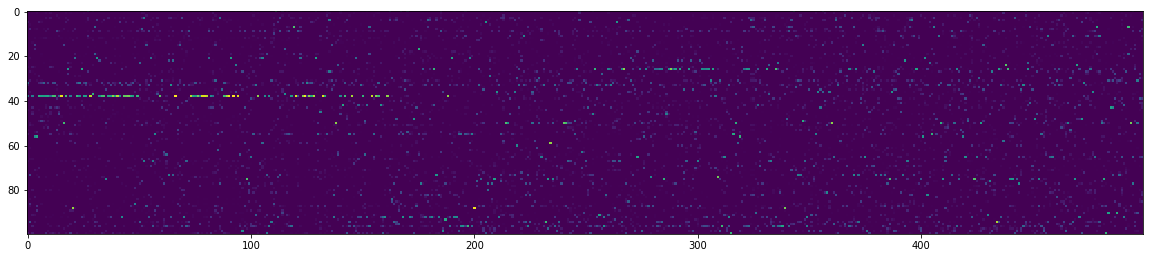

In [27]:
theta = best_model.transform_sparse(batch_vectorizer=batch_vec, eps=0.001)
print(f'shape theta: {theta[0].shape}')

plt.figure(figsize=(20, 20))
plt.imshow(theta[0][:, 2000:2500].toarray());

In [28]:
theta = best_model.transform(batch_vectorizer=batch_vec)
theta = theta.T
theta.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_90,topic_91,topic_92,topic_93,topic_94,topic_95,topic_96,topic_97,topic_98,topic_99
106000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
106001,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.058376,0.090986,0.039122,0.0
106002,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.037126,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
106003,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006004,...,0.0,0.030106,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
106004,0.056796,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.066202,...,0.0,0.032641,0.0,0.0,0.0,0.0,0.239502,0.000000,0.000000,0.0
